# Preliminary

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras
import sys

import numpy as np
import pickle, random, string
import matplotlib.pyplot as plt
%matplotlib inline

# Visualization
from IPython.display import display

from pathlib import Path

In [2]:
# Ugly patch becasue idk how to make this propperly work
#sys.path[0] += '/Codebase'
sys.path

['/home/jovyan/Extrapolation-Exploration/Codebase',
 '/opt/conda/lib/python39.zip',
 '/opt/conda/lib/python3.9',
 '/opt/conda/lib/python3.9/lib-dynload',
 '',
 '/opt/conda/lib/python3.9/site-packages']

In [3]:
#my classes
#from testClass import *
from transformerClasses import *
from embeddingClasses import *
from lstmClasses import *
from resourceFunctions import *

2022-08-07 23:42:31.588336: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-07 23:42:31.588376: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-07 23:42:31.588411: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-lak3r): /proc/driver/nvidia/version does not exist
2022-08-07 23:42:31.588795: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
strategy = tf.distribute.OneDeviceStrategy('gpu:1')
#Unsure if this is needed...

# Load outer Model

In [5]:
# setting up the pathlib stuff 
path = Path('..')
print([x for x in path.iterdir() if x.is_dir()])

path = path / 'saved-models'
outPath = path / 'outer_encdec_intembed'

encPathJson = outPath / 'encoder_len5_J_10000_intembed.json'
decPathJson = outPath / 'decoder_len5_J_10000_intembed.json'
encPathH5 = outPath / 'encoder_len5_J_10000_intembed.h5'
decPathH5 = outPath / 'decoder_len5_J_10000_intembed.h5'

[PosixPath('../.ipynb_checkpoints'), PosixPath('../saved-models'), PosixPath('../Qualifying-Exam-Writings'), PosixPath('../Codebase'), PosixPath('../Papers'), PosixPath('../data'), PosixPath('../.git')]


In [6]:
with encPathJson.open() as encoder_file, decPathJson.open() as decoder_file:
    encoder_json = encoder_file.read()
    decoder_json = decoder_file.read()
    
outer_encoder = keras.models.model_from_json(encoder_json)
outer_decoder = keras.models.model_from_json(decoder_json)

outer_encoder.load_weights(encPathH5)
outer_decoder.load_weights(decPathH5)

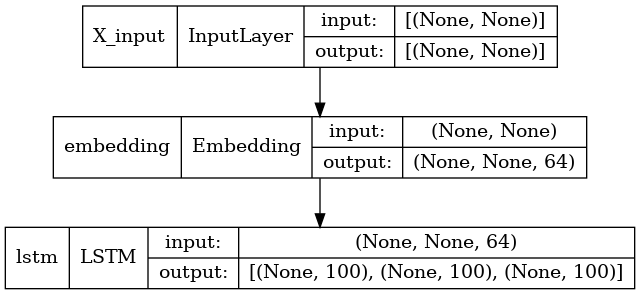

In [7]:
keras.utils.plot_model(outer_encoder, show_shapes=True)

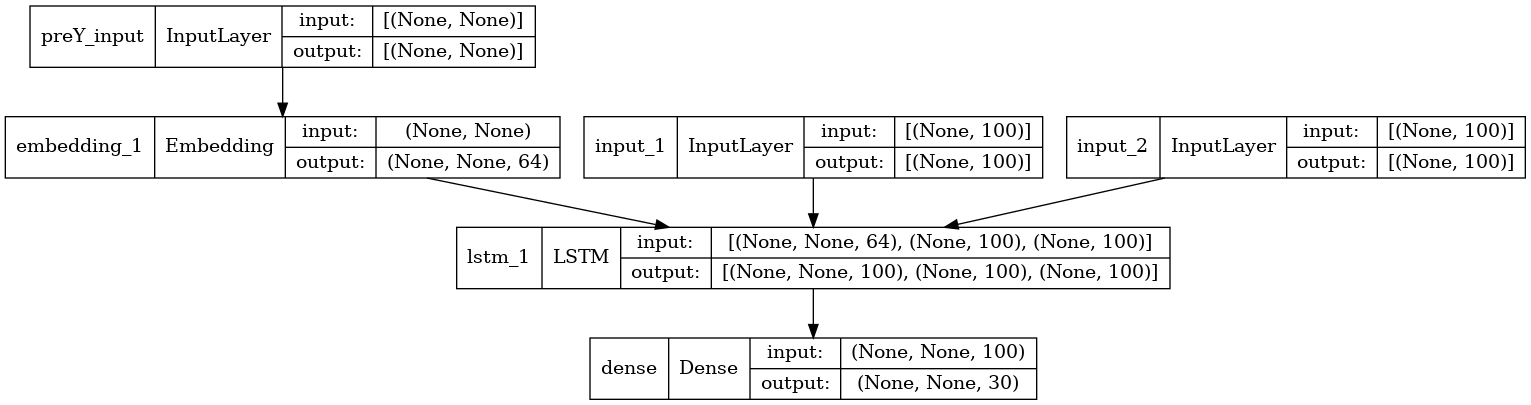

In [8]:
keras.utils.plot_model(outer_decoder, show_shapes=True)

# Load Input Data

In [9]:
# corpus = open('../data/len5_10000-train.txt')#corpus = np.loadtxt(sys.argv[1], dtype=object)
# corpus = np.loadtxt(corpus, dtype=object)

# trainingSet = open('../data/SG-10-train.txt')
# testingSet  = open('../data/SG-10-test.txt')

# trainingSet = np.loadtxt(trainingSet, dtype=str)
# testingSet  = np.loadtxt(testingSet, dtype=str)

# #Do note that I'm not confident in this

# Load training and testing data

# corpus = np.loadtxt(sys.argv[1], dtype=object)
# trainingSet = np.loadtxt(sys.argv[2], dtype=object)
# testingSet  = np.loadtxt(sys.argv[3], dtype=object)


#corpus = np.loadtxt(sys.argv[1], dtype=object)
corpus = (Path('..') / 'data' / 'len5_10000-train.txt' ).open() #open('../data/len5_10000-train.txt')
corpus = np.loadtxt(corpus, dtype=object)

trainingSet = (Path('..') / 'data' / 'SG-10-train.txt').open()
testingSet  = (Path('..') / 'data' / 'SG-10-test.txt').open()

trainingSet = np.loadtxt(trainingSet, dtype=str)
testingSet  = np.loadtxt(testingSet, dtype=str)

# Create Embeddings

In [10]:
# This is following the LSTM_LSTM file
# Ask about this. It seems that the embeddings go with the outer from my observation.
# Otherwise there is just something strange about the code that is causeing LSTM/LSTM to be different

In [11]:
# --- Create a dictionary for all the letters & start/stops ---
alphabet = np.array([i for i in range(1, 31)]) # All letters plus STARTSENTENCE, STOPSENTENCE, start, stop
mapping = dict()
for i in range(len(alphabet) - 4):
    mapping[chr(ord('a') + i)] = alphabet[i]

mapping['start'] = alphabet[26]
mapping['stop']  = alphabet[27]
mapping['STARTSETNENCE'] = alphabet[28]
mapping['STOPSENTENCE']  = alphabet[29]

In [12]:
# --- Map words from corpus to words to roles ---
encoded_mapping = {}
selected_words = {}
for letter in string.ascii_lowercase[:10]:
    # Store the letter with the word for use in testing
    rand_corpus_word = random.choice(corpus)

    word, Y, preY, postY = word_to_int(rand_corpus_word, mapping)
    
    selected_words[letter] = postY
    
    encoded_mapping[letter] = outer_encoder.predict(np.array([word]))

In [13]:
#--- Pre input to make encodings at the sentence level --- 
roles   = trainingSet #argv[2]    
x_train = []
for sentence in roles:
    x_train.append([encoded_mapping[letter] for letter in sentence])
x_train = np.array(x_train) # shape (n, 3, 2, 1, 50)

LENGTH_IDK  = x_train.shape[-1] # Replacing '50' in the code

t1 = x_train[:,:,0,0,:] # new shape (n,3,50)
t2 = x_train[:,:,1,0,:] # " '' "
# 4 time steps. pre
pre_t1 = np.concatenate((np.zeros((x_train.shape[0],1,LENGTH_IDK)), t1), axis = 1) # Orig. (x_train.shape[0], 1, 50)
pre_t2 = np.concatenate((np.zeros((x_train.shape[0],1,LENGTH_IDK)), t2), axis = 1)
post_t1 = np.concatenate((t1, np.zeros((x_train.shape[0],1,LENGTH_IDK))), axis = 1)
post_t2 = np.concatenate((t2, np.zeros((x_train.shape[0],1,LENGTH_IDK))), axis = 1)

In [14]:
# Start or stop tokens
s_s = {"start": [0,1], "stop": [1,0], "none": [0,0]}
pre_t3 = np.zeros((x_train.shape[0], 4, 2))
post_t3 = np.copy(pre_t3)
pre_t3[:,0,:] = s_s["start"]
post_t3[:,3,:] = s_s["stop"]

In [15]:
# This is following the Transformer_Transformer file

In [16]:
# # --- Create embeddings ---
# X, Y, preY, postY, mapping = letter_to_int(corpus)

In [17]:
# encoder_model = outer_encoder
# decoder_model = outer_decoder

In [18]:
# #sample 10 indices from the coprus WOR
# corIdx = np.random.randint(0,high=len(corpus),size=20)
# #I could probably just do a np array of size 10000 
# corIdx = np.random.choice(corIdx,size=10,replace=False)

# outer_x = X[corIdx]
# outer_preY = preY[corIdx]
# outer_postY = postY[corIdx]

# outer_embeddings = outer_encoder.predict(outer_x)

# trainingSet_int = letter_to_int(trainingSet)[0]

# testingSet_int = letter_to_int(testingSet)[0]

# # inner_x = np.array([outer_embeddings[trainingSet_int[x]-1] for x in range(len(trainingSet))]) #200 comes from the trainingSet 
# # inner_x_testing = np.array([outer_embeddings[testingSet_int[x]-1] for x in range(len(testingSet))])

In [19]:
# outer_embeddings

In [20]:
# #need testing inner_postY_testing
# dog = np.zeros((1,5,300))
# dog.shape
# np.concatenate((dog, inner_x[0]))

In [21]:
# #make inner_postY and outer_postY
# dog = np.zeros((1,5,300))
# inner_preY = np.array([np.concatenate((dog,inner_x[i])) for i in range(len(inner_x))])
# inner_postY = np.array([np.concatenate((inner_x[i],dog)) for i in range(len(inner_x))])

In [22]:
# #testing postY and preY
# dog = np.zeros((1,5,300))
# dog.shape
# np.concatenate((dog, inner_x_testing[0]))

In [23]:
# dog = np.zeros((1,5,300))
# inner_preY_testing = np.array([np.concatenate((dog,inner_x_testing[i])) for i in range(len(inner_x_testing))])
# inner_postY_testing = np.array([np.concatenate((inner_x_testing[i],dog)) for i in range(len(inner_x_testing))])

In [24]:
# # --- Make start and stop tokens ---
# s_s = {"start":[1,0],"stop":[0,1], "none":[0,0]}
# pre_start = np.zeros((inner_x.shape[0], 4, 2))
# post_stop = np.zeros((inner_x.shape[0], 4, 2))
# pre_start[:,0,:] = s_s["start"]
# post_stop[:,3,:] = s_s["stop"]

# Inner Transformer

In [25]:
#Now I'm working from the Transformer_Transformer file

In [26]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [27]:
# --- Model parameters ---
length = 10
padded_length = 20

In [28]:
# Note we are making these the same, but they don't -have- to be!
input_length = padded_length
output_length = padded_length

In [29]:
# Vocabulary sizes...
encoder_vocab_size = 30 # a, b, c, ... z, start, stop, STARTSENTENCE, STOPSENTENCE
decoder_vocab_size = 30 # a, b, c, ... z, start, stop, STARTSENTENCE, STOPSENTENCE

In [30]:
# Size of the gestalt, context representations...
embed_dim = 128  # Embedding size for each token (enc/dec inputs already embedded)
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
stack = 1
wd = 0.01

In [31]:
HIDDEN_SIZE = 300
BATCH_SIZE  = 50
EPOCHS      = 250

In [48]:
# --- Construct inner encoder/decoder ---
with strategy.scope():
    # Encoder
    #The next two lines are what you need to look at.
    encoder_input = keras.layers.Input(shape=(None,) + x_train.shape[2:], name="inner_enc_token")
    #hhmmm
    #encoder_cat = keras.layers.Concatenate(axis=3)(encoder_input)

    encoder_reshape = keras.layers.Reshape((-1,1500))(encoder_input)

    encoder_embedding = keras.layers.Dense(embed_dim)(encoder_reshape)

    encoder_mask_pos_embedding = InnerMaskedPositionEmbedding(maxlen=input_length,
                                                              embed_dim=encoder_embedding.shape[-1])(encoder_embedding)

    encoder_state = InnerTransformerBlock(embed_dim=encoder_embedding.shape[-1], num_heads=num_heads,ff_dim=ff_dim)(encoder_mask_pos_embedding)
    
    encoder_model = keras.Model(encoder_input,encoder_state,name="InnerEncoder")
    
#keras.utils.plot_model(encoder_model, expand_nested=True, show_shapes=True)

    # Decoder
    #double check this junction as above (two input and a cat)
    decoder_input = keras.layers.Input(shape=(None,) + pre_t1.shape[2:], name="inner_dec_token")

    decoder_context_input = keras.layers.Input(shape=encoder_state.shape[1:], name='inner_enc_state')

    decoder_reshape = keras.layers.Reshape((-1,1500))(decoder_input)

    decoder_startstop = keras.layers.Input(shape=(None, 2), name="dec_start/stop")

    decoder_inputs = [decoder_context_input, decoder_input, decoder_startstop]

    decoder_concat = keras.layers.Concatenate()([decoder_reshape, decoder_startstop])

    decoder_embedding = keras.layers.Dense(embed_dim)(decoder_concat)

    decoder_mask_pos_embedding = InnerMaskedPositionEmbedding(maxlen=pre_t1.shape[1],
                                                         embed_dim=decoder_embedding.shape[-1])(decoder_embedding)

    decoder_block = InnerMaskedTransformerBlock(embed_dim=decoder_mask_pos_embedding.shape[-1],
                                           num_heads=num_heads,
                                           ff_dim=ff_dim)

    decoder_hidden_output = decoder_block([decoder_mask_pos_embedding, decoder_context_input])

    x = keras.layers.Dense(post_t1.shape[2]*embed_dim)(decoder_hidden_output)

    #pay attention to this too
    # First tho do a dense layer to project from imbeddim to 200
    # Suggested as making the reshape 2,100
    # Then make a lambda layer to make this 2 100 layers
    inner_output_reshape = keras.layers.Reshape((-1,post_t1.shape[-2],embed_dim))(x)

    decoder_dense_t1 = keras.layers.Dense(post_t1.shape[-1], activation='linear', name="output_token")(inner_output_reshape)

    decoder_dense_startstop = keras.layers.Dense(2, activation='sigmoid', name="start/stop")(decoder_hidden_output)

    decoder_outputs = [decoder_dense_t1, decoder_dense_startstop]

    decoder_model = keras.Model(decoder_inputs,decoder_outputs,name="InnerDecoder")
    
    # Tie encoder and decoder into one model
    #with strategy.scope():
    #model = keras.Model([encoder_input]+ decoder_inputs, decoder_outputs)
    coupled_inputs = [keras.layers.Input(encoder_model.inputs[0].shape[1:]),
                      keras.layers.Input(decoder_model.inputs[1].shape[1:]),
                      keras.layers.Input(decoder_model.inputs[2].shape[1:])]                     
    coupled_outputs = decoder_model([encoder_model(coupled_inputs[0])] + coupled_inputs[1:])
    model = keras.Model(coupled_inputs, coupled_outputs)

    # --- Compile and fit model ---
    model.compile(loss = [keras.losses.MSE,keras.losses.binary_crossentropy],
               optimizer=keras.optimizers.Adam(),
               metrics=['accuracy'])

    model_input = {"inner_enc_token":x_train, "inner_dec_token":pre_t1,
                         "dec_start/stop":pre_t3}
    model_target = {"output_token":post_t1, "start/stop": post_t3}

    #with strategy.scope():
    # history = model.fit([x_train,pre_t1, pre_t3], [post_t1,post_t3],
    #                      batch_size=BATCH_SIZE,
    #                      epochs=EPOCHS,
    #                      verbose=0)


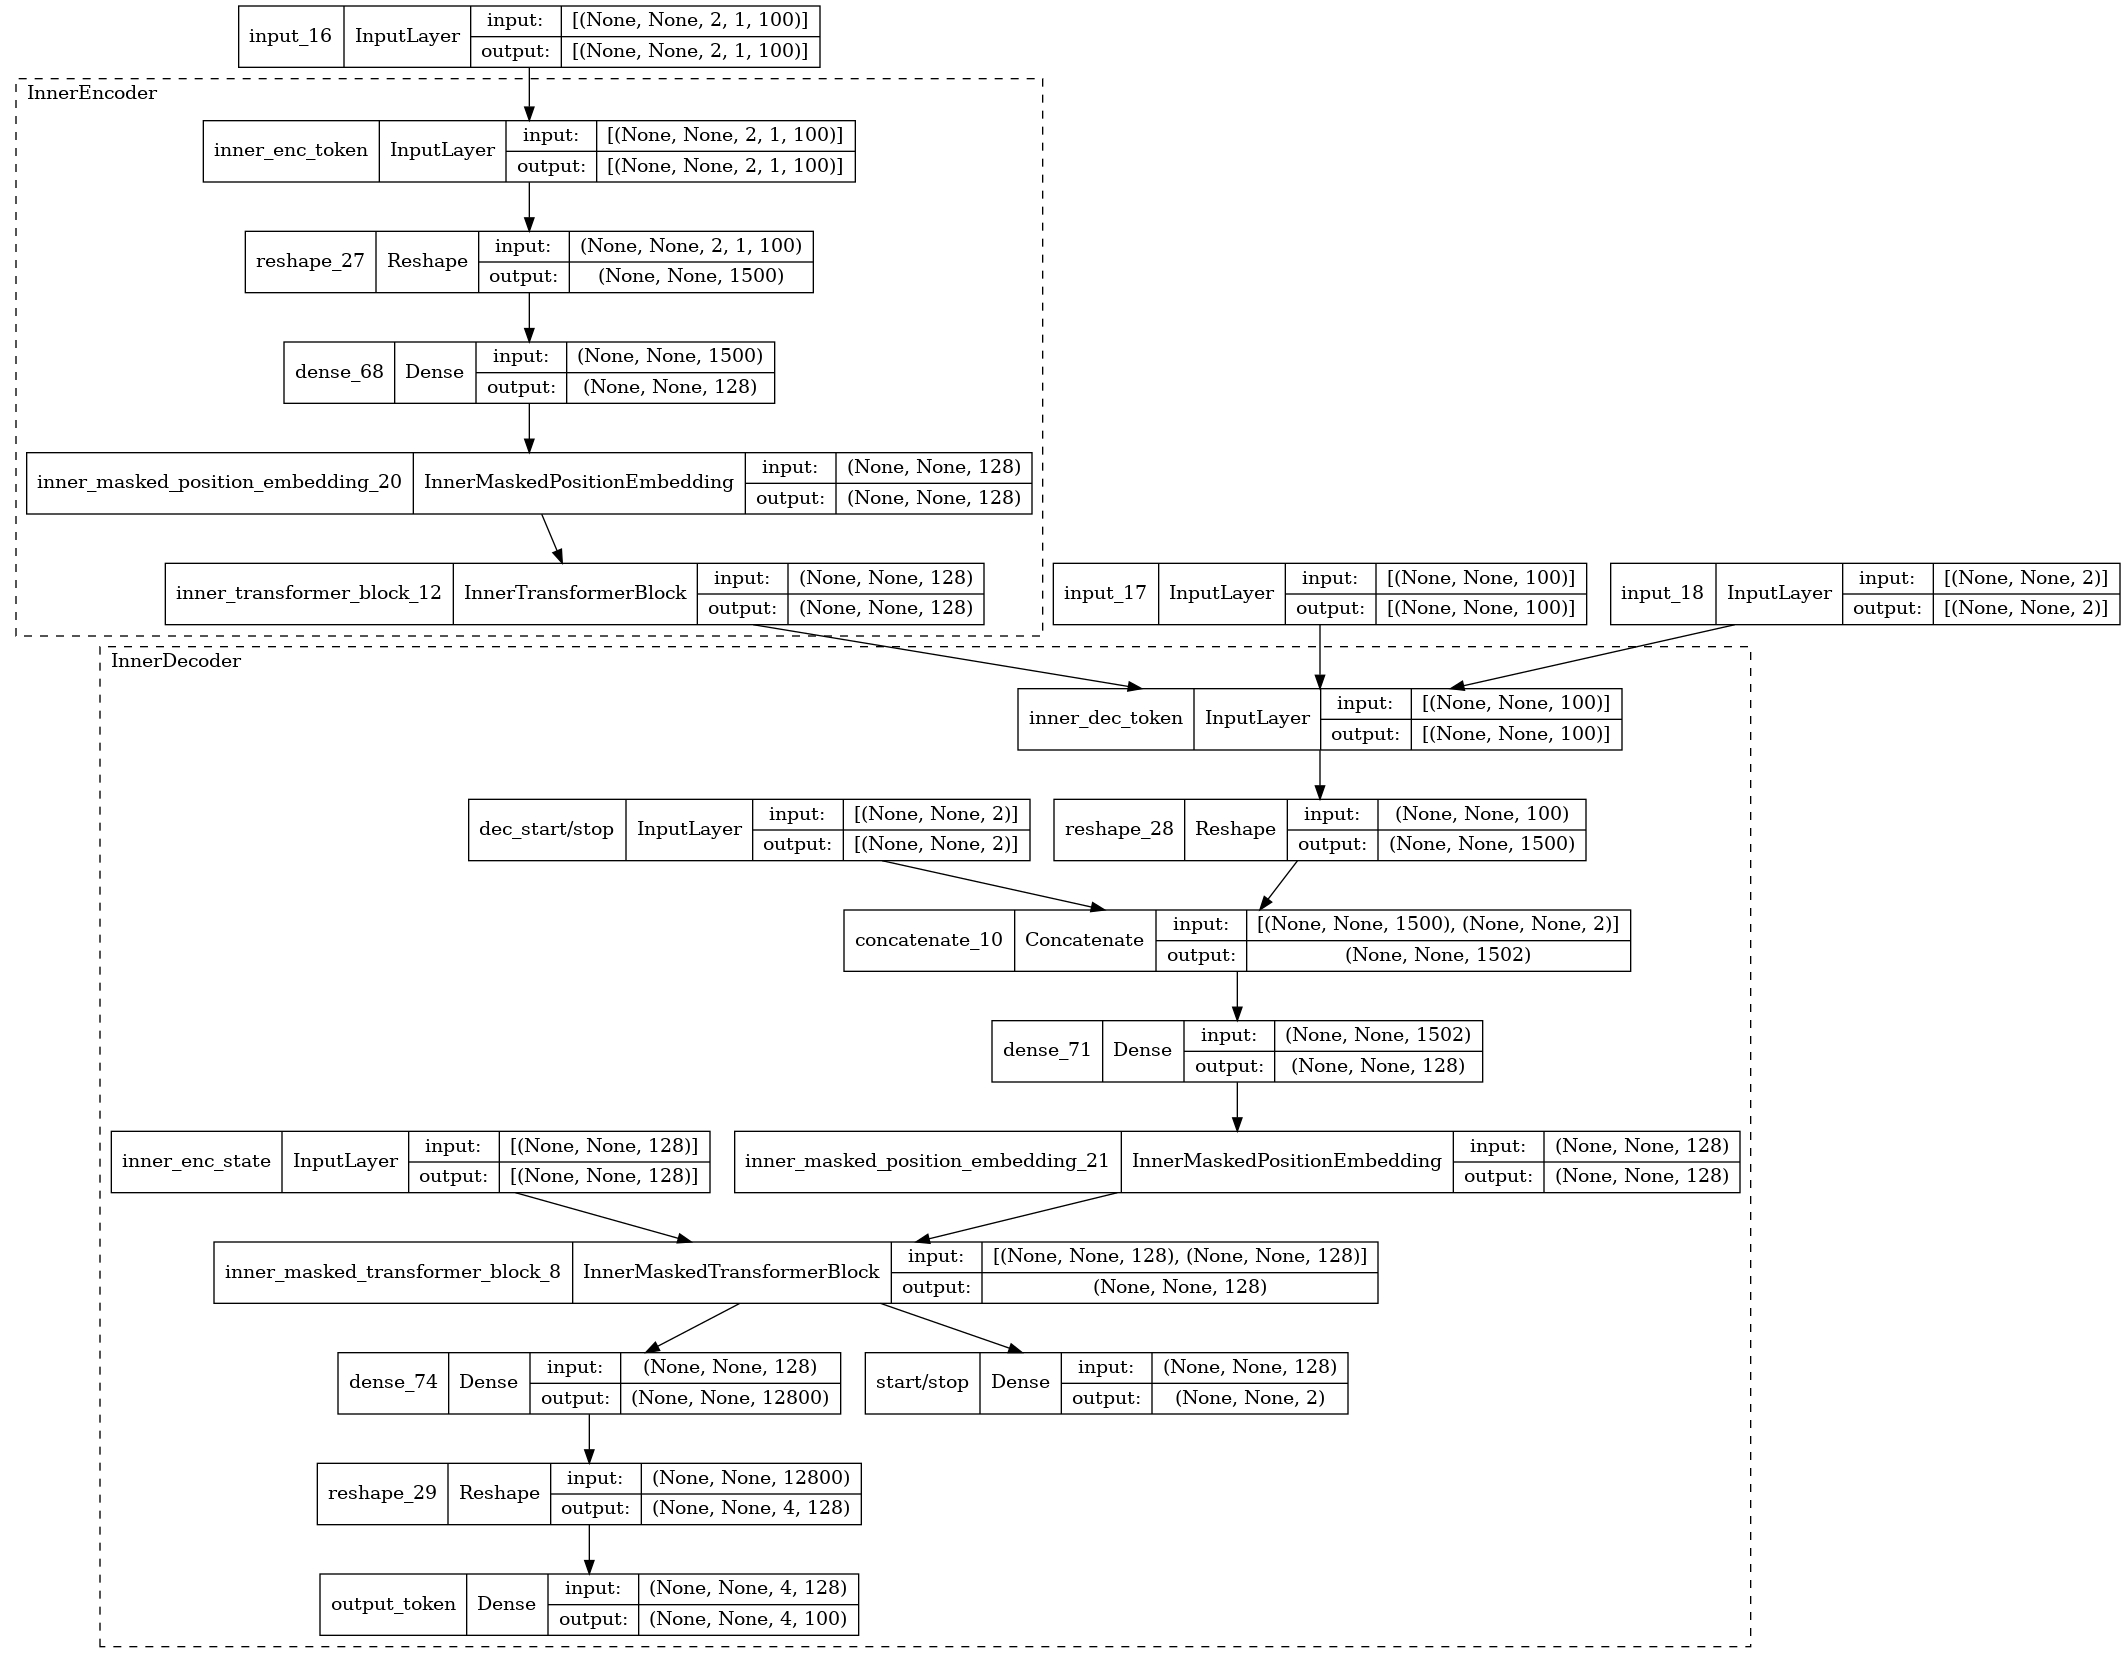

In [49]:
keras.utils.plot_model(model, expand_nested=True, show_shapes=True)